# KYC: know your collegues (based on OpenFace & FaceNet)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
from keras.models import load_model
import cv2
import dlib
import utils
import pickle
import glob
import skimage.transform as tr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K
from tqdm import tqdm
from cnn import get_model, load_weights
from process import ProcessFaces
IMG_SIZE = 96
print('available devices: ', [x.name for x in K.tensorflow_backend.device_lib.list_local_devices()])

Using TensorFlow backend.


available devices:  ['/device:CPU:0', '/device:XLA_CPU:0']


### 1. Loading CNN and pretrained weights

In [2]:
%%time
#---load model, weigths and save if needed---
model = get_model(input_shape=(IMG_SIZE, IMG_SIZE, 3))
#load weights if needed and save
model = load_weights(model)
model.save('./data/model.h5')
#---load trained model---
#model = load_model('./data/model.h5', custom_objects={'tf': tf})

Instructions for updating:
Colocations handled automatically by placer.
CPU times: user 5.99 s, sys: 156 ms, total: 6.14 s
Wall time: 6.05 s


/opt/cloudera/parcels/Anaconda-5.3.1-dsai1.6/envs/python3.6.6/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### 2. Images preprocess

In [3]:
#labels, paths = ProcessFaces().process_all() #only initial run
labels_raw, paths_raw = ProcessFaces().get_labels_paths_raw()
labels, paths = ProcessFaces().get_labels_paths_proc()
print(len(labels_raw), len(labels))
print(len(set(labels_raw)), len(set(labels)))
print(set(labels_raw) - set(labels))

25989 26022
25989 25927
{'44380', '128607', '26692', '34100', '33801', '118705', '121395', '197967', '179692', '12862', '18461', '55000', '110184', '112995', '19834', '21049', '36994', '42691', '30916', '114063', '196258', '66454', '12750', '136614', '181773', '186609', '180899', '47185', '21207', '19958', '187074', '192155', '113610', '184459', '181258', '127699', '16965', '201103', '115208', '109459', '23401', '206202', '5335', '194923', '203070', '127863', '191611', '113340', '128645', '126862', '10716', '193758', '138677', '136242', '38474', '51900', '183372', '46258', '120203', '8536', '25427', '50674'}


### 3. Recognition utils

In [3]:
def image_to_embedding(image, model):
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) 
    img = image[..., ::-1]
    img = np.around(np.transpose(img, (0, 1, 2)) / 255., decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding
def find_identity(img, database, model, level=.92):
    min_dist = 100.
    identity = None
    img_embedding = image_to_embedding(img, model)
    for (label, data) in database.items():
        dist = np.linalg.norm(data[4] - img_embedding)
        if dist < min_dist:
            min_dist = dist
            identity = data[0]
    print(min_dist)
    if min_dist < level:
        return identity
    else:
        return None
def find_faces_img(img, database, model):
    font = cv2.FONT_HERSHEY_SIMPLEX
    color = (0, 255, 0)
    font_scale = max(img.shape[0], img.shape[0]) / 700
    line_scale = round(3 * font_scale)
    shift_x = 5
    shift_y = int(shift_x * font_scale)
    faces = ProcessFaces().get_faces_rects(img, 1)
    for face_rect in faces:
        img_face = ProcessFaces().align_face(img, face_rect)
        (x, y, w, h) = ProcessFaces().get_face_xywh(face_rect)
        identity = find_identity(img_face, database, model)
        print(identity)
        if identity is not None:
            x1 = x
            y1 = y
            x2 = x + w
            y2 = y + h
            img = cv2.rectangle(img, (x1, y1), (x2, y2), color, line_scale)
            cv2.putText(img, str(identity), (x1 + shift_x, y1 - shift_y), font, font_scale, color, line_scale)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

### 4. Create database of identities

In [4]:
def translit(text):
    symbols = ('абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ ',
               'abvgdeejzijklmnoprstufhccss_yieuaABVGDEEJZIJKLMNOPRSTUFHCCSS_YIEUA ')
    tr = {ord(a):ord(b) for a, b in zip(*symbols)}
    return text.translate(tr)
def prepare_database(df_data, model, path='./user_photos_x96/*'):
    database = {}
    for file in tqdm(glob.glob(path), total=len(glob.glob(path))):
        label = os.path.splitext(os.path.basename(file))[0][len('user_photo_'):][:-len('_x')]
        name = ' '.join(df_data[df_data['0'] == int(label)]['1'].values[0].split()[:2])
        department = df_data[df_data['0'] == int(label)]['6'].values[0].strip()
        subject = df_data[df_data['0'] == int(label)]['7'].values[0].strip()
        img = cv2.imread(file, 1)
        database[label] = (translit(name), department, subject, file, image_to_embedding(img, model))
    return database
def update_database(database, model, path='./update_photos/*'):
    label = 900000
    for file in tqdm(glob.glob(path), total=len(glob.glob(path))):
        label += 1 
        name = os.path.splitext(os.path.basename(file))[0]
        department, subject = 'Updated', 'Updated'
        upd_img = cv2.imread(file, 1)
        faces = ProcessFaces().get_faces_rects(upd_img, 1)
        for face_rect in faces:
            img_face = ProcessFaces().align_face(upd_img, face_rect)
            img_face = img_face.astype(int)
            database[label] = (name, department, subject, file, image_to_embedding(img_face, model))
    return database

In [5]:
%%time
#---prepare full base---
#df_data = pd.read_csv('./hr_scraping_20190403.csv', encoding='cp1251')
#database = prepare_database(df_data, model, path='./user_photos_x96/*')
#with open('./data/database.pkl', 'wb') as file:
#    pickle.dump(database, file)
#---load full base and filter by condition---
with open('./data/database.pkl', 'rb') as file:
    database = pickle.load(file)
database_cut = {k: v for k, v in database.items() if v[2] == 'Цифровая трансформация' }
database_cut = update_database(database_cut, model, path='./update_photos/*')
add_people = [
    '183555',
    '197646',
    '106799',
]
database_cut.update({k: v for k, v in database.items() if k in add_people})

100%|██████████| 7/7 [00:26<00:00,  3.70s/it]

CPU times: user 26.4 s, sys: 699 ms, total: 27.1 s
Wall time: 26.4 s


### 5. Find face on arbitary picture

0.57455426
Ostroumov Anton
0.9165633
Koceruba Andrej
0.7061595
Vasiliy_Garshin
0.99516165
None


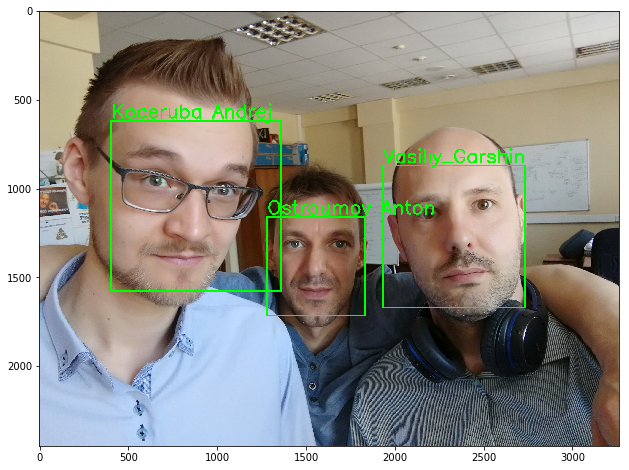

(2448, 3264, 3)
CPU times: user 21.2 s, sys: 637 ms, total: 21.9 s
Wall time: 21.4 s


In [7]:
%%time
photo_path = './test_photos/*'
photo_files = glob.glob(photo_path)
test_img = photo_files[30]
img = cv2.imread(test_img)
img_proc = find_faces_img(img, database_cut, model)
plt.figure(figsize=(16, 8))
plt.imshow(img_proc)
plt.show()
print(img_proc.shape)